# Comparative analysis of metabolic cell communication

In this tutorial, we will give an example to show how to compare metabolic cell communication under two condition. As an example, the mouse brain with Parkinson's disease in [[Marco et al., 2023](https://www.nature.com/articles/s41587-023-01937-y)] has intact region and lesion region. Therefore, we can compare the differential MCC signals between this two conditions.

In [1]:
# Importing packages
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt

import metachat as mc

In [2]:
# Setting your work dictionary
os.chdir("/home/Project/MetaChat_test/mouse_brain")

For the spatial data after inference by tutorial, we can download results data from [zenodo](https://zenodo.org/records/12629999).

In [4]:
adata = sc.read('data/adata_results.h5ad')

## Use of Napari for dividing districts

First, we need to install the squidpy package with Napari by using `pip install 'squidpy[interactive]'` in your environment.

:::{seealso}
For basic usage of Napari, please see the [tutorial](https://metachat.readthedocs.io/en/latest/tutorials/realistic_data/multi-omics_data_LRC.html) and [Squidpy document](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_napari.html#annotate-tissue-regions-with-the-shape-layer). 
:::

In [5]:
image = adata.uns['spatial']['V11L12-109_B1']['images']['hires']
img = sq.im.ImageContainer(image, library_id='V11L12-109_B1', scale=adata.uns['spatial']['V11L12-109_B1']['scalefactors']['tissue_hires_scalef'])
viewer = img.interactive(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


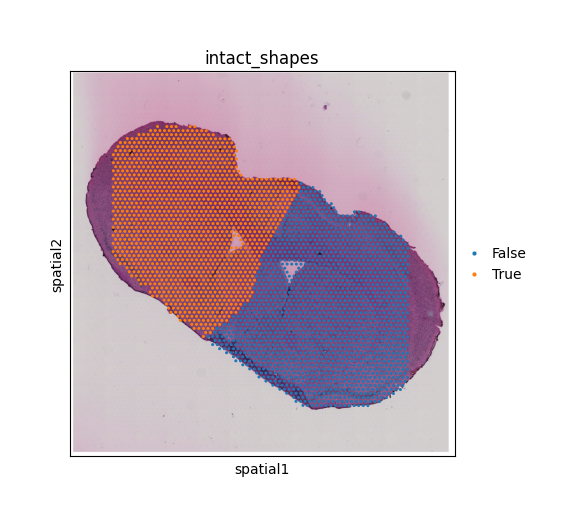

In [7]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(figsize = (6,5))
sq.pl.spatial_scatter(adata,
                      color = 'intact_shapes',
                      alpha = 1,
                      ax = ax)
ax.set_box_aspect(1)

## Comparative analysis

We construct an adata object containing MCC intensities, i.e., we replace the features in the gene expression matrix with MCC signals.

In [4]:
MCC_matrix_sender = adata.obsm['MetaChat-MetaChatDB-sum-sender']
MCC_matrix_sender = MCC_matrix_sender.iloc[:,:-1]
MCC_matrix_receiver = adata.obsm['MetaChat-MetaChatDB-sum-receiver']
MCC_matrix_receiver = MCC_matrix_receiver.iloc[:,:-1]
MCC_matrix = pd.concat([MCC_matrix_sender, MCC_matrix_receiver], axis=1)
adata_MCC = sc.AnnData(MCC_matrix)
adata_MCC.uns['spatial'] = adata.uns['spatial']
adata_MCC.obsm['spatial'] = adata.obsm['spatial']

We find spatially variable MCC signals with high Moran’s I Score.

In [5]:
sq.gr.spatial_neighbors(adata_MCC)
sq.gr.spatial_autocorr(
    adata_MCC,
    mode = "moran",
    n_perms = 100,
    n_jobs = 1,
)

  0%|          | 0/100 [00:00<?, ?/s]

In [6]:
adata_MCC.var_names_make_unique()
sc.pp.normalize_total(adata_MCC, inplace=True)
adata_MCC = adata_MCC[:, adata_MCC.uns["moranI"].index[:200]]

In [7]:
adata_MCC.obs['intact_shapes'] = adata.obs['intact_shapes'].copy()
adata_MCC.uns['intact_shapes_colors'] = adata.uns['intact_shapes_colors'].copy()
adata_MCC.obs['tissue_type'] = adata.obs['tissue_type'].copy()

In [8]:
adata_MCC.obs['disease_group'] = 0
adata_MCC.obs['disease_group'][adata_MCC.obs['intact_shapes'] == True] = 'Intact'
adata_MCC.obs['disease_group'][adata_MCC.obs['intact_shapes'] == False] = 'Lesion'

Identify differential MCC signals.

In [9]:
sc.tl.rank_genes_groups(adata_MCC, groupby="disease_group", method="wilcoxon")

In [10]:
DEG_result = sc.get.rank_genes_groups_df(adata_MCC, group="Intact")

Differential MCC signals are foucs on dopamine (HMDB0000073) and norepinephrine (HMDB0000216).

In [11]:
DEG_result.head()

,names,scores,logfoldchanges,pvals,pvals_adj
0,s-HMDB0000216-Adrb1,22.211687,2.730860,2.648043e-109,5.296085e-107
1,s-HMDB0000216-Adra2c,14.247141,2.017829,4.670153e-46,4.670153e-44
2,s-HMDB0000073-Drd1,13.821672,2.191979,1.886347e-43,1.257565e-41
3,s-HMDB0000216-Adra1b,13.602405,2.975367,3.874813e-42,1.937406e-40
4,s-HMDB0000073-Drd2,13.535527,2.357271,9.648753e-42,3.859501e-40


Draw a diagram of a volcano

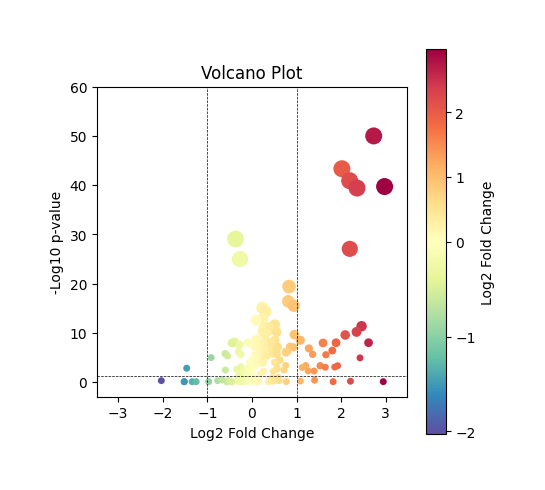

In [12]:
DEG_result['neg_log10_pValue'] = -np.log10(DEG_result['pvals_adj']).copy()
DEG_result['neg_log10_pValue'][DEG_result['neg_log10_pValue'] > 50] = 50
DEG_result['point_size'] = DEG_result['neg_log10_pValue'].copy()
DEG_result['point_size'][DEG_result['point_size'] < 5] = 5
DEG_result['point_size'][DEG_result['point_size'] > 30] = 30

from matplotlib.colors import TwoSlopeNorm
fig, ax = plt.subplots(figsize = (5,5))

vmin = np.min(DEG_result['logfoldchanges'])
vmax = np.max(DEG_result['logfoldchanges'])
vcenter = 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

scatter = ax.scatter(x=DEG_result['logfoldchanges'], y=DEG_result['neg_log10_pValue'],
                     c=DEG_result['logfoldchanges'], s=5*DEG_result['point_size'], cmap='Spectral_r', norm = norm)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Log2 Fold Change')

max_fold_change = np.max(np.abs(DEG_result['logfoldchanges'])) + 0.5
ax.set_xlim(-max_fold_change, max_fold_change)
ax.set_ylim(-3, 60)
ax.set_title('Volcano Plot')
ax.set_xlabel('Log2 Fold Change')
ax.set_ylabel('-Log10 p-value')
ax.axhline(y=-np.log10(0.05), color='black', linestyle='--')
ax.axvline(x=1, color='black', linestyle='--')
ax.axvline(x=-1, color='black', linestyle='--')

ax.set_box_aspect(1)

Divided the adata into two section intact and lesion.

In [13]:
adata_intact = adata[adata.obs['intact_shapes'] == True,:]
adata_lesion = adata[adata.obs['intact_shapes'] == False,:]

Summary the communication associated with HMDB0000216 and HMDB0000073 in intact and lesion region, respecetively.

In [14]:
sum_metabolites = ['HMDB0000216','HMDB0000073']
mc.tl.summary_communication(adata = adata_intact,
                            database_name = 'MetaChatDB',
                            sum_metabolites = sum_metabolites)
mc.tl.summary_communication(adata = adata_lesion,
                            database_name = 'MetaChatDB',
                            sum_metabolites = sum_metabolites)

Construct the group-level MCC in intact and lesion region, respecetively.

In [15]:
mc.tl.communication_group(adata = adata_intact,
                          database_name = 'MetaChatDB',
                          group_name = "tissue_type",
                          sum_metabolites = sum_metabolites,
                          n_permutations = 100)
mc.tl.communication_group(adata = adata_lesion,
                          database_name = 'MetaChatDB',
                          group_name = "tissue_type",
                          sum_metabolites = sum_metabolites,
                          n_permutations = 100)

Plot the hierarchy diagram to compare the group-level MCC between intact and lesion region.

<Axes: >

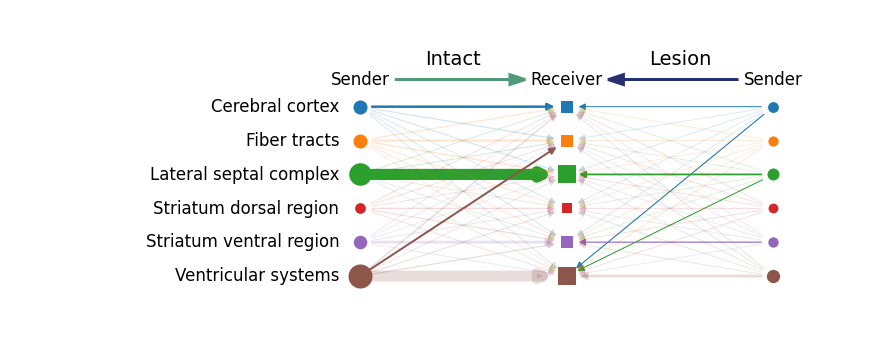

In [16]:
mc.pl.plot_group_communication_compare_hierarchy_diagram(adata_A = adata_intact,
                                                         adata_B = adata_lesion,
                                                         condition_name_A = "Intact",
                                                         condition_name_B = "Lesion",
                                                         database_name = 'MetaChatDB',
                                                         group_name = 'tissue_type',
                                                         metabolite_name = "HMDB0000216",
                                                         permutation_spatial = False,
                                                         p_value_cutoff = 0.05,
                                                         node_sizes_limit = (50,300),
                                                         edge_sizes_limit = (0.5,8),
                                                         group_cmap = None,
                                                         alpha = 0.2,
                                                         figsize = (10, 3))

<Axes: >

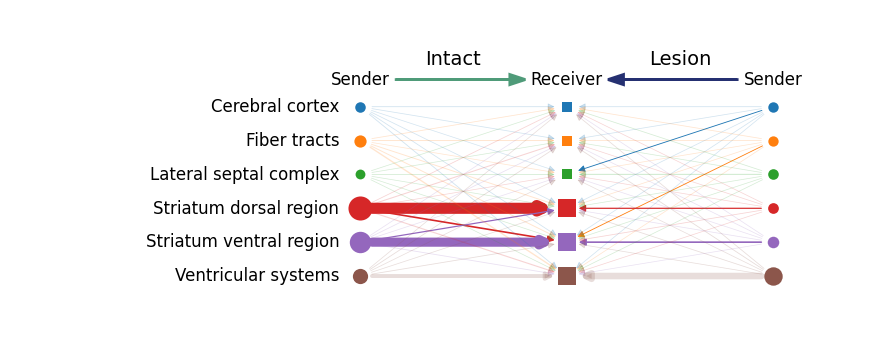

In [17]:
mc.pl.plot_group_communication_compare_hierarchy_diagram(adata_A = adata_intact,
                                                         adata_B = adata_lesion,
                                                         condition_name_A = "Intact",
                                                         condition_name_B = "Lesion",
                                                         database_name = 'MetaChatDB',
                                                         group_name = 'tissue_type',
                                                         metabolite_name = "HMDB0000073",
                                                         permutation_spatial = False,
                                                         p_value_cutoff = 0.05,
                                                         node_sizes_limit = (50,300),
                                                         edge_sizes_limit = (0.5,8),
                                                         group_cmap = None,
                                                         alpha = 0.2,
                                                         figsize = (10, 3))